In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hdbscan
from matplotlib.lines import Line2D 
import re   
import umap
import os
import warnings
from utils import clean_text
warnings.filterwarnings('ignore')

# Load data

Veganuary data

In [4]:
# open retrieved_videos_metrics mformer
videos_metrics_mformer_veg = pd.read_csv("./data/retrieved_videos_mformer.csv")

# open retrieved_videos_metrics_baseline mformer
videos_metrics_baseline_mformer_veg = pd.read_csv("./data/retrieved_videos_mformer_baseline.csv")

FileNotFoundError: [Errno 2] No such file or directory: './data/retrieved_videos_mformer.csv'

Meatless march data

In [ ]:
# open retrieved_videos_metrics mformer 
videos_metrics_mformer_march = pd.read_csv("./data/meatlessmarch/retrieved_videos_mformer.csv")

# open retrieved_videos_metrics_baseline mformer
videos_metrics_baseline_mformer_march = pd.read_csv("./data/meatlessmarch/retrieved_videos_mformer_baseline.csv")

No Meat May data

In [ ]:
# open retrieved_videos_metrics mformer 
videos_metrics_mformer_may = pd.read_csv("./data/nomeatmay/retrieved_videos_mformer.csv")

# open retrieved_videos_metrics_baseline mformer
videos_metrics_baseline_mformer_may = pd.read_csv("./data/nomeatmay/retrieved_videos_mformer_baseline.csv")

# Moral foundations scores scaling

Scale moral foundation values

In [ ]:
for moral_value in ["care_score", "fairness_score", "loyalty_score", "authority_score", "sanctity_score"]:
    
    ## veganuary
    # get baseline IQR
    q1 = videos_metrics_baseline_mformer_veg[moral_value].quantile(0.25)
    q3 = videos_metrics_baseline_mformer_veg[moral_value].quantile(0.75)
    iqr = q3 - q1
    videos_metrics_mformer_veg[moral_value+"_adj"] = (videos_metrics_mformer_veg[moral_value]-videos_metrics_baseline_mformer_veg[moral_value].median())/iqr

    ## meatlessmarch
    # get baseline IQR
    q1 = videos_metrics_baseline_mformer_march[moral_value].quantile(0.25)
    q3 = videos_metrics_baseline_mformer_march[moral_value].quantile(0.75)
    iqr = q3 - q1
    videos_metrics_mformer_march[moral_value+"_adj"] = (videos_metrics_mformer_march[moral_value]-videos_metrics_baseline_mformer_march[moral_value].median())/iqr

    ## nomeatmay
    # get baseline IQR
    q1 = videos_metrics_baseline_mformer_may[moral_value].quantile(0.25)
    q3 = videos_metrics_baseline_mformer_may[moral_value].quantile(0.75)
    iqr = q3 - q1
    videos_metrics_mformer_may[moral_value+"_adj"] = (videos_metrics_mformer_may[moral_value]-videos_metrics_baseline_mformer_may[moral_value].median())/iqr

Zscores

In [ ]:
# z-score moral foundations
moral_values = ["care_score_adj", "fairness_score_adj", "loyalty_score_adj", "authority_score_adj", "sanctity_score_adj"]

# z-score moral foundations
videos_metrics_mformer_veg[moral_values] = videos_metrics_mformer_veg[moral_values].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
videos_metrics_mformer_march[moral_values] = videos_metrics_mformer_march[moral_values].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
videos_metrics_mformer_may[moral_values] = videos_metrics_mformer_may[moral_values].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

Combine all data

In [ ]:
# concatenate the two dataframes
videos_metrics_mformer = pd.concat([videos_metrics_mformer_veg, videos_metrics_mformer_march, videos_metrics_mformer_may])
videos_metrics_baseline_mformer = pd.concat([videos_metrics_baseline_mformer_veg, videos_metrics_baseline_mformer_march, videos_metrics_baseline_mformer_may])

# Collective identity markers extraction

Define function for pronouns extraction

In [ ]:
first_person_sing_pronouns = ['i', 'me', 'my', 'mine', 'myself']
first_person_plur_pronouns = ['we', 'us', 'our', 'ours', 'ourselves']


def collective_identity_index(text):
    first_person_sing = 0
    first_person_plur = 0
    tot_words = 0

    for word in text.split():

        if word.lower() in first_person_sing_pronouns:
            first_person_sing += 1
        elif word.lower() in first_person_plur_pronouns:
            first_person_plur += 1

        tot_words+=1
    
    score_I_we = 0.5 + 0.5 * (first_person_sing - first_person_plur) / (first_person_sing + first_person_plur + 1)

    return score_I_we

Extract Collective Identity index (CI index)

In [ ]:
# apply clean function to Video Transcript column
videos_metrics_mformer['Video Transcript Clean'] = videos_metrics_mformer['Video Transcript'].apply(lambda x: clean_text(x))
# remove all rows for which Video Transcript Clean is empty and reset index
videos_metrics_mformer = videos_metrics_mformer[videos_metrics_mformer['Video Transcript Clean'] != ''].reset_index(drop=True)

videos_metrics_mformer["ci_index"] = videos_metrics_mformer['Video Transcript Clean'].apply(lambda x: collective_identity_index(x))

# 1st step: Group into communal-oriented and agency-oriented based on CI index

Text(0, 0.5, 'Frequency')

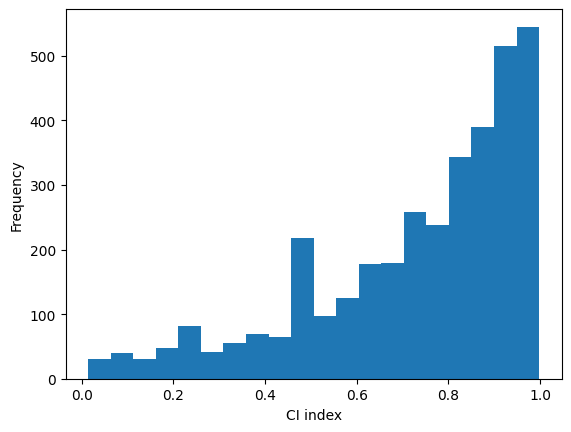

In [ ]:
# visualize distribution of ci_index
plt.hist(videos_metrics_mformer["ci_index"], bins=20)

# x axis label
plt.xlabel("CI index")
# y axis label
plt.ylabel("Frequency")

Split CI index into communal-oriented, neutral and agency-oriented

In [ ]:
# save dataframe subsets
communal_oriented = videos_metrics_mformer[videos_metrics_mformer["ci_index"] <= 0.4]
agency_oriented = videos_metrics_mformer[videos_metrics_mformer["ci_index"] >= 0.6]
neutral = videos_metrics_mformer[(videos_metrics_mformer["ci_index"] > 0.4) & (videos_metrics_mformer["ci_index"] < 0.6)]

# print sizes
print("Communal-oriented size: ", communal_oriented.shape[0])
print("Agency-oriented size: ", agency_oriented.shape[0])
print("Neutral size: ", neutral.shape[0])

Communal-oriented size:  389
Agency-oriented size:  2656
Neutral size:  502


# 2nd step: within each identity orientation, cluster into groups based on moral foundation scores

## Communal-oriented

Apply UMAP to reduce dimensionality

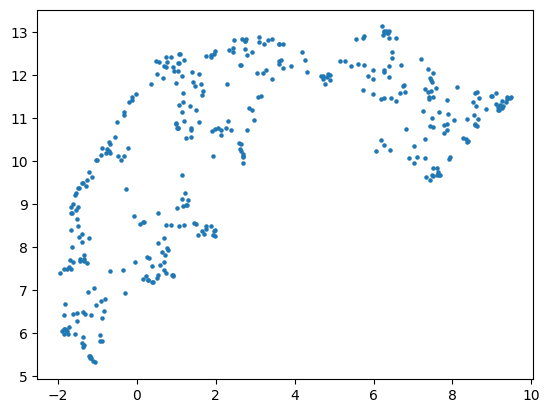

In [12]:
# define features
features = ['care_score_adj', 'fairness_score_adj', 'loyalty_score_adj', 'authority_score_adj', 'sanctity_score_adj']

# convert NaN values to 0
communal_oriented[features] = communal_oriented[features].fillna(0)

# umap for communal_oriented
reducer = umap.UMAP(random_state=42)
embedding_group = reducer.fit_transform(communal_oriented[features])

# reset index in communal_oriented
communal_oriented = communal_oriented.reset_index(drop=True)

# plot the embedding, color by narrative column values
plt.scatter(embedding_group[:, 0], embedding_group[:, 1],  s=5)

### HDBSCAN clustering

Parameters optimization function (min_samples, min_cluster_size, metric)

In [13]:
def extensive_search_params(param_dist, train_clusterable_embedding):
    
    scores = []

    # iterate over all possible combinations of parameters
    for min_sample in param_dist["min_samples"]:
        for min_clust_size in param_dist["min_cluster_size"]:
            for metric_type in param_dist["metric"]:

                clusterer = hdbscan.HDBSCAN(min_cluster_size=min_clust_size, min_samples=min_sample, cluster_selection_method='eom', metric=metric_type, gen_min_span_tree=True)

                # Fit the data to the clusterer
                cluster_labels = clusterer.fit_predict(train_clusterable_embedding)

                print("min sample:", min_sample, "|",
                "min cluster size:", min_clust_size, "|",
                "metric", metric_type, "|",
                "validity:", clusterer.relative_validity_, flush=True)
                
                # porint number of clusters
                print("Number of clusters:", len(set(cluster_labels)))
                
                scores.append([min_sample, min_clust_size, metric_type, clusterer.relative_validity_])
                
    max_score = max(map(lambda x: x[3], scores))
    
    list_best = [x for x in scores if x[3]==max_score][0]
    
    return list_best[0], list_best[1], list_best[2]

Define parameters search and run optimization

In [14]:
param_dist = {'min_samples': [2,3,5,7,10,15,20],
              'min_cluster_size':[15,20,30,40,50,60,70,80,90,100,110,120],
              'metric':["euclidean", "manhattan"]}

best_min_sample, best_min_cluster_size, best_metric = extensive_search_params(param_dist, embedding_group)

print(best_min_sample, best_min_cluster_size, best_metric)


min sample: 2 | min cluster size: 15 | metric euclidean | validity: 0.08948035999963665
Number of clusters: 13
min sample: 2 | min cluster size: 15 | metric manhattan | validity: 0.11694969439669771
Number of clusters: 11
min sample: 2 | min cluster size: 20 | metric euclidean | validity: 0.10736615798720066
Number of clusters: 10
min sample: 2 | min cluster size: 20 | metric manhattan | validity: 0.11944657699586157
Number of clusters: 10
min sample: 2 | min cluster size: 30 | metric euclidean | validity: 0.10935501443629446
Number of clusters: 7
min sample: 2 | min cluster size: 30 | metric manhattan | validity: 0.12013319880226082
Number of clusters: 8
min sample: 2 | min cluster size: 40 | metric euclidean | validity: 0.08997078654406383
Number of clusters: 6
min sample: 2 | min cluster size: 40 | metric manhattan | validity: 0.09489790145387844
Number of clusters: 6
min sample: 2 | min cluster size: 50 | metric euclidean | validity: 0.08997078654406383
Number of clusters: 6
min sa

Visualize HDBSCAN clusters

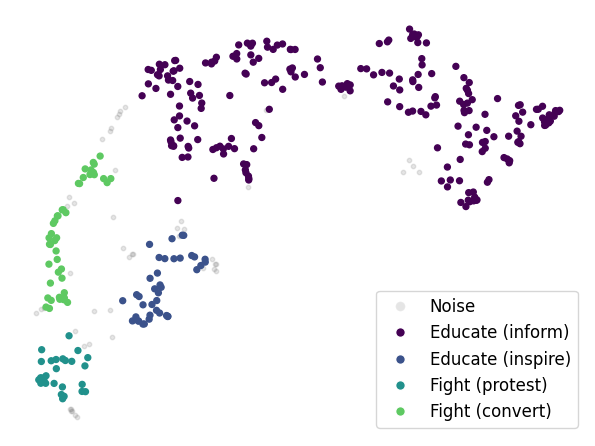

In [15]:
# set sans-serif font
plt.rcParams["font.family"] = "sans-serif"

# HDBSCAN for communal_oriented given best parameters
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_sample, cluster_selection_method='eom', metric=best_metric, prediction_data=True)
cluster_labels = clusterer.fit_predict(embedding_group)

# get count of cluster labels
unique_labels, counts_elements = np.unique(cluster_labels, return_counts=True)

# add cluster labels to dataframe
communal_oriented["hdbscan_labels"] = cluster_labels

# reset index
communal_oriented = communal_oriented.reset_index(drop=True)

# for each video, print probability of belonging to each cluster
prob = hdbscan.all_points_membership_vectors(clusterer)
# as dataframe
prob_df = pd.DataFrame(prob, columns=["Cluster "+str(i) for i in range(len(prob[0]))])
# print numbers with 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# add probability columns to dataframe
for i in range(len(prob[0])):
    communal_oriented["prob_cluster"+str(i)] = prob_df["Cluster "+str(i)]

## Plot UMAP embedding with cluster labels
    
# choose colors for cluster labels, setting "grey" for -1 cluster. 
colors = [plt.cm.viridis(each) for each in np.linspace(0, 1, len(unique_labels))]
if -1 in unique_labels:
    colors.insert(0, (0.5, 0.5, 0.5, 1.0))


dict_colors = {}
for i in range(len(unique_labels)):
    dict_colors[unique_labels[i]] = colors[i]

# set list of length = number of samples, with color for each sample
color = [dict_colors[i] for i in cluster_labels if i!=-1]

# plot the embedding for points corresponding to cluster -1
plt.scatter(embedding_group[cluster_labels==-1, 0], embedding_group[cluster_labels==-1, 1], s=10, c="grey", alpha=0.2)
# plot the embedding for points corresponding to clusters 0, 1, 2, 3
plt.scatter(embedding_group[cluster_labels!=-1, 0], embedding_group[cluster_labels!=-1, 1], s=18, c=color)

plt.tight_layout()

# custom legends from color dictionary
legend_elements = []
for i in unique_labels:
    if i == 0:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Educate (inform)', markerfacecolor=dict_colors[i], markersize=7))
    elif i == 1:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Educate (inspire)', markerfacecolor=dict_colors[i], markersize=7))
    elif i == 2:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Fight (protest)', markerfacecolor=dict_colors[i], markersize=7))
    elif i == 3:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Fight (convert)', markerfacecolor=dict_colors[i], markersize=7))
    else:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Noise', markerfacecolor=dict_colors[i], markersize=7, alpha=0.2))

# remove x axis ticks and labels
plt.xticks([])
# remove y axis ticks and labels
plt.yticks([])
# remove borders
plt.box(False)
# add legend
plt.legend(handles=legend_elements, fontsize=12)

# if pics folder does not exist, create it
if not os.path.exists('./pics'):
    os.makedirs('./pics')

# save as svg
plt.savefig("./pics/group_hdbscan.svg", format="svg")

Get cluster centroids by taking the mean of UMAP coordinates for each cluster

In [16]:
cluster_centroids = pd.DataFrame()
for i in range(len(unique_labels)):
    # get cluster centroid
    cluster_centroid = embedding_group[cluster_labels == unique_labels[i]].mean(axis=0)
    # add to dataframe
    cluster_centroids = cluster_centroids.append(pd.DataFrame(cluster_centroid).T)

Get samples close to cluster centroids in terms of UMAP embedding

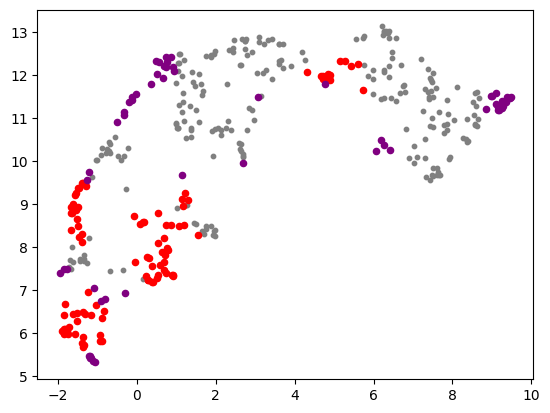

In [18]:
# set distance threshold
threshold_sim = 1
threshold_dist = 2
n_samples = 30

# initialize dataframes
samples_close = pd.DataFrame()
samples_close_elements_df = []
samples_far = pd.DataFrame()
samples_far_elements_df = []

# for each cluster
for i in range(len(cluster_centroids)):
    # compute difference between each sample in cluster i and cluster centroid within the same cluster
    diff = embedding_group[cluster_labels == unique_labels[i]] - cluster_centroids.iloc[i].tolist()
    # compute euclidean distance
    euclidean_dist = np.linalg.norm(diff, axis=1)

    # get samples close to cluster centroid, within the same cluster
    samples_close_i = embedding_group[cluster_labels == unique_labels[i]][(euclidean_dist < threshold_sim)]
    # indices of samples close to cluster centroid, within the same cluster
    indices_close_i = communal_oriented[cluster_labels == unique_labels[i]][(euclidean_dist < threshold_sim)].index

    # get samples far from cluster centroid but within the same cluster
    samples_far_i = embedding_group[cluster_labels == unique_labels[i]][(euclidean_dist > threshold_dist)]
    # indices of samples close to cluster centroid
    indices_far_i = communal_oriented[cluster_labels == unique_labels[i]][(euclidean_dist > threshold_dist)].index

    # take n_samples elements close to cluster centroid
    # order by euclidean distance
    samples_close_i = samples_close_i[np.argsort(euclidean_dist[(euclidean_dist < threshold_sim)])][:n_samples]
    # get indices of samples close to cluster centroid from indices_close_i
    indices_close_i = indices_close_i[np.argsort(euclidean_dist[(euclidean_dist < threshold_sim)])][:n_samples]
    # convert to dataframe
    samples_close_i = pd.DataFrame(samples_close_i, columns=["x", "y"])
    # add cluster label
    samples_close_i["cluster"] = [i for j in range(len(samples_close_i))]
    # add to dataframe
    samples_close = samples_close.append(samples_close_i)

    # take n_samples elements far from cluster centroid
    samples_far_i = samples_far_i[np.argsort(euclidean_dist[(euclidean_dist > threshold_dist)])][::-1][:n_samples]
    # get indices of samples close to cluster centroid from indices_close_i
    indices_far_i = indices_far_i[np.argsort(euclidean_dist[(euclidean_dist > threshold_dist)])][::-1][:n_samples]
    # convert to dataframe
    samples_far_i = pd.DataFrame(samples_far_i, columns=["x", "y"])
    # add cluster label
    samples_far_i["cluster"] = [i for j in range(len(samples_far_i))]
    # add to dataframe
    samples_far = samples_far.append(samples_far_i)

    # from communal_oriented, get elements with index in indices_close_i
    samples_close_elements = communal_oriented[communal_oriented.index.isin(indices_close_i)]
    # add distance from cluster centroid as column
    samples_close_elements["dist"] = euclidean_dist[(euclidean_dist < threshold_sim)][np.argsort(euclidean_dist[(euclidean_dist < threshold_sim)])][:n_samples]
    # add pca coordinates as columns
    samples_close_elements["x"] = samples_close_i["x"].tolist()
    samples_close_elements["y"] = samples_close_i["y"].tolist()
    samples_close_elements_df.append(samples_close_elements)

    # from communal_oriented, get elements with index in indices_far_i
    samples_far_elements = communal_oriented[communal_oriented.index.isin(indices_far_i)]
    # add distance from cluster centroid as column
    samples_far_elements["dist"] = euclidean_dist[(euclidean_dist > threshold_dist)][np.argsort(euclidean_dist[(euclidean_dist > threshold_dist)])][::-1][:n_samples]
    # add pca coordinates as columns
    samples_far_elements["x"] = samples_far_i["x"].tolist()
    samples_far_elements["y"] = samples_far_i["y"].tolist()
    samples_far_elements_df.append(samples_far_elements)

samples_close_elements_df = pd.concat(samples_close_elements_df)
samples_far_elements_df = pd.concat(samples_far_elements_df)


# plot the embedding, color by cluster labels and highlight samples close to cluster centroids
plt.scatter(embedding_group[:, 0], embedding_group[:, 1], c="grey", s=10)
plt.scatter(samples_close["x"], samples_close["y"], c="red", s=20)
plt.scatter(samples_far["x"], samples_far["y"], c="purple", s=20)

# save samples_close_elements to csv in an easily readable format for the Video Transcript column
samples_close_elements_df[["Video Transcript", "dist", "hdbscan_labels"]].to_csv("./data/examples/samples_mformer_wisescale_all_group_noscaled0_text_n30.csv", index=False)




The output of the previous chunk is the input of Llama + manual validation

Characterize narratives by moral scores

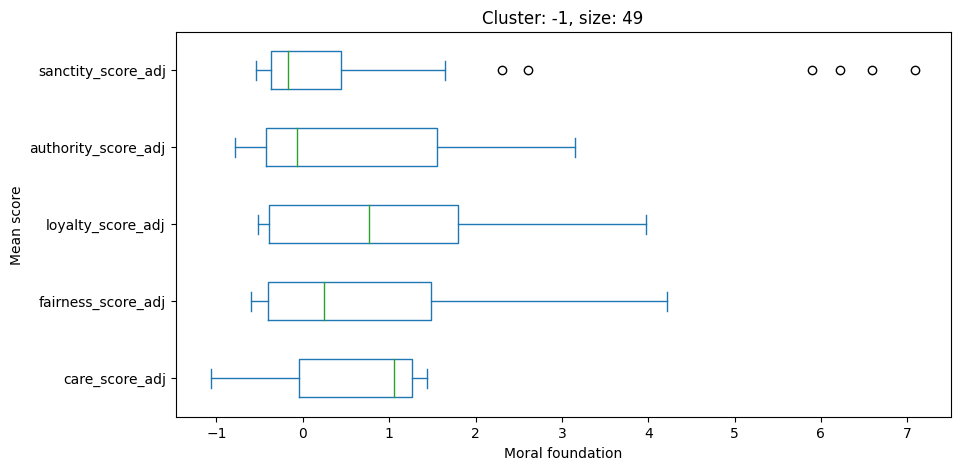

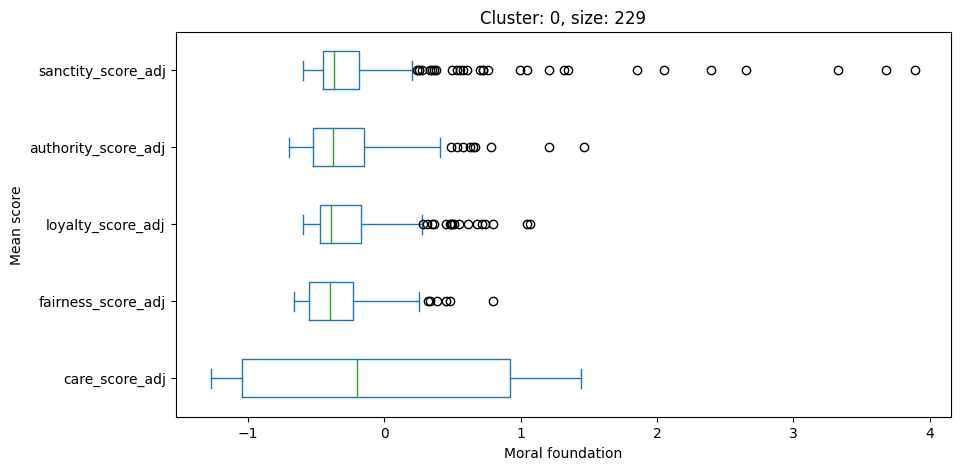

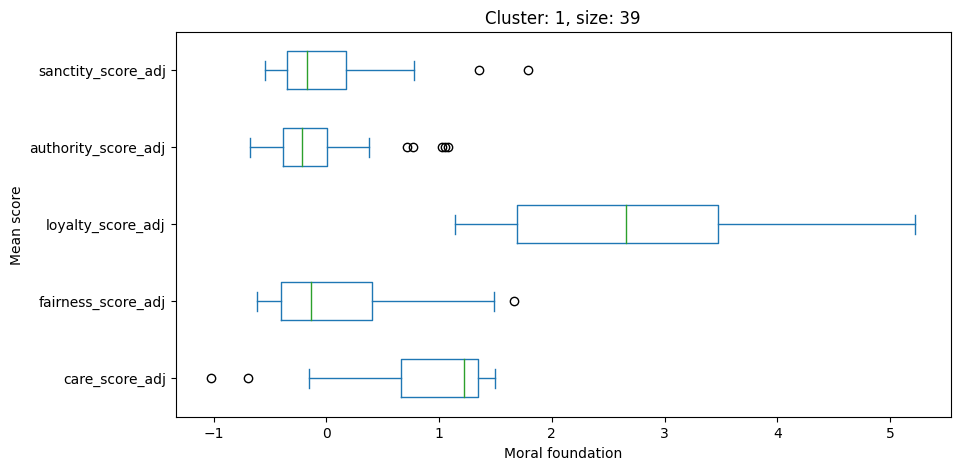

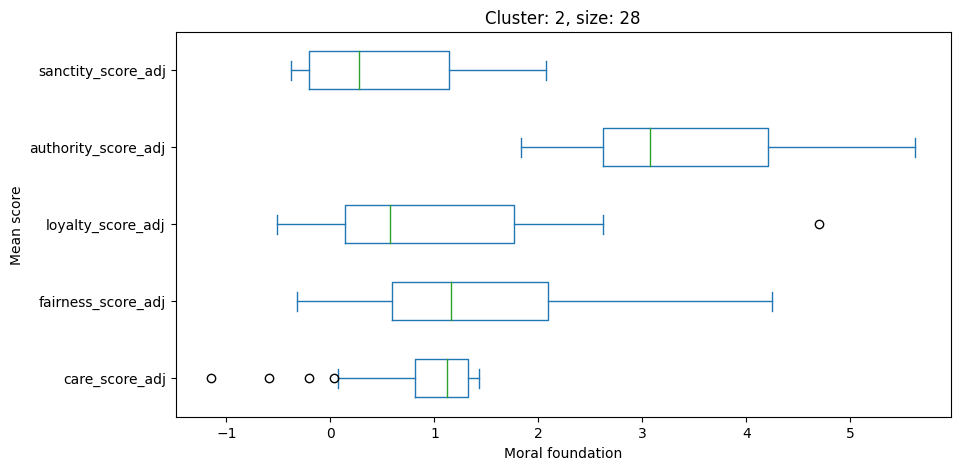

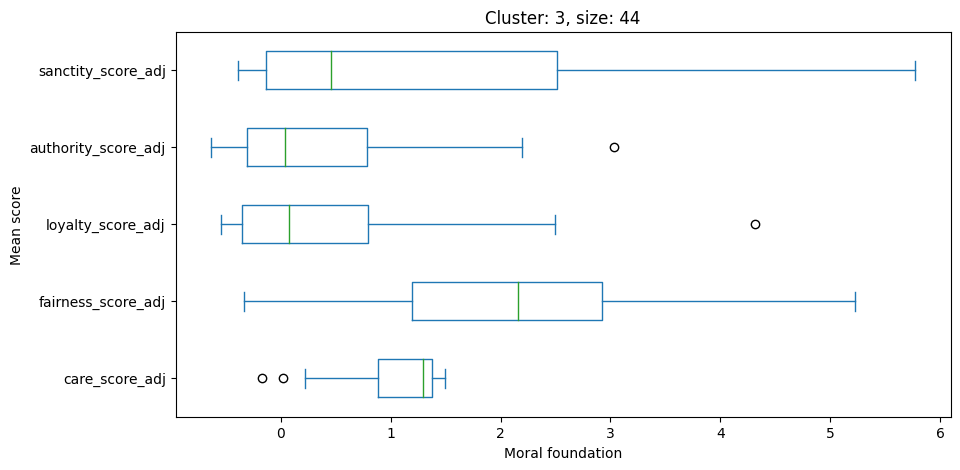

In [109]:
# for each cluster not equal to -1
for i in unique_labels:
    # if i==-1:
    #     continue

    # define columns to save
    prob_cols = ["prob_cluster"+str(i) for i in range(len(prob[0]))]
    other_cols = ["Video ID", "Video Transcript", "ci_index", 'care_score_adj', 'fairness_score_adj', 'loyalty_score_adj', 'authority_score_adj', 'sanctity_score_adj']

    # save examples of videos in the cluster
    communal_oriented[communal_oriented["hdbscan_labels"]==i][other_cols+prob_cols].to_csv("./data/examples/group_mformer_wisescale_all_noscaled0_cl_"+str(i)+".csv", index=False)
    
    # get cluster data
    cluster = communal_oriented[communal_oriented["hdbscan_labels"]==i]
    # plot barplot for each moral foundation, with confidence intervals
    cluster[moral_values].plot(kind="box", vert=False, figsize=(10, 5))
    # set x axis label
    plt.xlabel("Moral foundation")
    # set y axis label
    plt.ylabel("Mean score")
    # set plot title
    plt.title("Cluster: "+str(i)+", size: "+str(len(cluster)))
    # save png
    plt.savefig("./pics/group_mformer_wisescale_all_noscaled0_cl_"+str(i)+".png", format="png")

## Agency-oriented

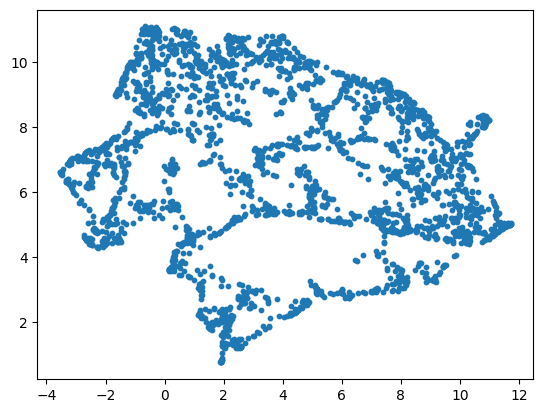

In [97]:
# define features
features = ['care_score_adj', 'fairness_score_adj', 'loyalty_score_adj', 'authority_score_adj', 'sanctity_score_adj']

# convert NaN values to 0
agency_oriented[features] = agency_oriented[features].fillna(0)

# reset index
agency_oriented = agency_oriented.reset_index(drop=True)

# umap for communal_oriented
reducer = umap.UMAP(random_state=42)
embedding_self = reducer.fit_transform(agency_oriented[features])

# plot the embedding, color by narrative column values
plt.scatter(embedding_self[:, 0], embedding_self[:, 1],  s=10)

### HDBSCAN clustering

Define parameters search and run optimization

In [98]:
param_dist = {'min_samples': [2,5,10,15,20,30],
              'min_cluster_size':[80,90,100,120,130,150,160,170,180,190,200,250,300,400,500,700],
              'metric':["euclidean", "manhattan"]}

best_min_sample, best_min_cluster_size, best_metric = extensive_search_params(param_dist, embedding_self)

print(best_min_sample, best_min_cluster_size, best_metric)

min sample: 2 | min cluster size: 80 | metric euclidean | validity: 0.022145200034319443
Number of clusters: 9
min sample: 2 | min cluster size: 80 | metric manhattan | validity: 0.017648461217590797
Number of clusters: 7
min sample: 2 | min cluster size: 90 | metric euclidean | validity: 0.022145200034319443
Number of clusters: 9
min sample: 2 | min cluster size: 90 | metric manhattan | validity: 0.017648461217590797
Number of clusters: 7
min sample: 2 | min cluster size: 100 | metric euclidean | validity: 0.017676000992031544
Number of clusters: 8
min sample: 2 | min cluster size: 100 | metric manhattan | validity: 0.017648461217590797
Number of clusters: 7
min sample: 2 | min cluster size: 120 | metric euclidean | validity: 0.017676000992031544
Number of clusters: 8
min sample: 2 | min cluster size: 120 | metric manhattan | validity: 0.013734793514477876
Number of clusters: 6
min sample: 2 | min cluster size: 130 | metric euclidean | validity: 0.02108958458717311
Number of clusters:

Visualize HDBSCAN clusters

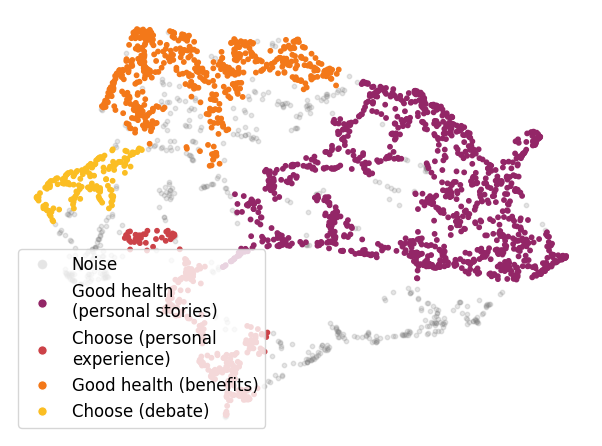

In [99]:
# set font to sans-serif
plt.rcParams["font.family"] = "sans-serif"

# HDBSCAN for communal_oriented
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_sample, cluster_selection_method='eom', metric=best_metric, prediction_data=True)
cluster_labels = clusterer.fit_predict(embedding_self)

# get count of cluster labels
unique_labels, counts_elements = np.unique(cluster_labels, return_counts=True)

# add cluster labels to dataframe
agency_oriented["hdbscan_labels"] = cluster_labels

# reset index
agency_oriented = agency_oriented.reset_index(drop=True)

# for each video, print probability of belonging to each cluster
prob = hdbscan.all_points_membership_vectors(clusterer)
# as dataframe
prob_df = pd.DataFrame(prob, columns=["Cluster "+str(i) for i in range(len(prob[0]))])
# print numbers with 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# add probability columns to dataframe
for i in range(len(prob[0])):
    agency_oriented["prob_cluster"+str(i)] = prob_df["Cluster "+str(i)]

## Plot UMAP embedding with cluster labels 
colors = [plt.cm.inferno(each) for each in np.linspace(0.4, 1, len(unique_labels))]
# add grey color at the beginning
if -1 in unique_labels:
    colors.insert(0, (0.5, 0.5, 0.5, 1.0))

dict_colors = {}
for i in range(len(unique_labels)):
    dict_colors[unique_labels[i]] = colors[i]

# set list of length = number of samples, with color for each sample
color = [dict_colors[i] for i in cluster_labels if i!=-1]

# plot the embedding for points corresponding to cluster -1
plt.scatter(embedding_self[cluster_labels==-1, 0], embedding_self[cluster_labels==-1, 1], s=10, c="grey", alpha=0.2)
# plot the embedding for points corresponding to clusters 0, 1, 2, 3
plt.scatter(embedding_self[cluster_labels!=-1, 0], embedding_self[cluster_labels!=-1, 1], s=10, c=color)

# increase white spae around plot
plt.tight_layout()

# custom legends from color dictionary
legend_elements = []
for i in unique_labels:
    if i == 0:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Good health\n(personal stories)', markerfacecolor=dict_colors[i], markersize=7))
    elif i == 1:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Choose (personal\nexperience)', markerfacecolor=dict_colors[i], markersize=7))
    elif i == 2:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Good health (benefits)', markerfacecolor=dict_colors[i], markersize=7))
    elif i == 3:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Choose (debate)', markerfacecolor=dict_colors[i], markersize=7))
    else:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Noise', markerfacecolor=dict_colors[i], markersize=7, alpha=0.2))

# remove x axis ticks and labels
plt.xticks([])
# remove y axis ticks and labels
plt.yticks([])
# remove borders
plt.box(False)
# add legend
plt.legend(handles=legend_elements, fontsize=12, loc="lower left")

# save as svg
plt.savefig("./pics/self_hdbscan.svg", format="svg")

Get cluster centroids by taking the mean of UMAP coordinates for each cluster

In [100]:
cluster_centroids = pd.DataFrame()
for i in range(len(unique_labels)):
    # get cluster centroid
    cluster_centroid = embedding_self[cluster_labels == unique_labels[i]].mean(axis=0)
    # add to dataframe
    cluster_centroids = cluster_centroids.append(pd.DataFrame(cluster_centroid).T)

Get samples close to cluster centroids in terms of UMAP embedding


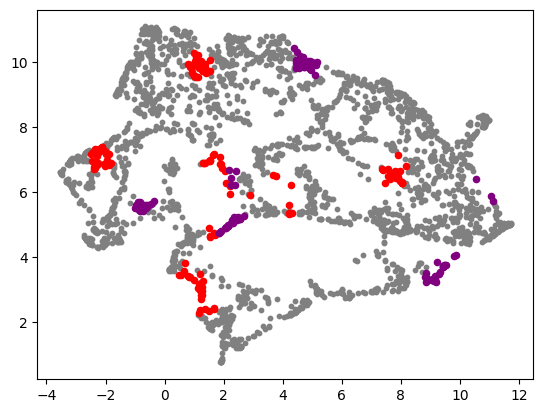

In [101]:
# set distance threshold
threshold_sim = 2
threshold_dist = 3
n_samples = 30

# initialize dataframe
samples_close = pd.DataFrame()
samples_close_elements_df = []
samples_far = pd.DataFrame()
samples_far_elements_df = []

# for each cluster
for i in range(len(cluster_centroids)):
    # compute difference between each sample in cluster i and cluster centroid within the same cluster
    diff = embedding_self[cluster_labels == unique_labels[i]] - cluster_centroids.iloc[i].tolist()
    # compute euclidean distance
    euclidean_dist = np.linalg.norm(diff, axis=1)

    # get samples close to cluster centroid, within the same cluster
    samples_close_i = embedding_self[cluster_labels == unique_labels[i]][(euclidean_dist < threshold_sim)]
    # indices of samples close to cluster centroid, within the same cluster
    indices_close_i = agency_oriented[cluster_labels == unique_labels[i]][(euclidean_dist < threshold_sim)].index

    # get samples far from cluster centroid but within the same cluster
    samples_far_i = embedding_self[cluster_labels == unique_labels[i]][(euclidean_dist > threshold_dist)]
    # indices of samples close to cluster centroid
    indices_far_i = agency_oriented[cluster_labels == unique_labels[i]][(euclidean_dist > threshold_dist)].index

    # take n_samples elements close to cluster centroid
    # order by euclidean distance
    samples_close_i = samples_close_i[np.argsort(euclidean_dist[(euclidean_dist < threshold_sim)])][:n_samples]
    # get indices of samples close to cluster centroid from indices_close_i
    indices_close_i = indices_close_i[np.argsort(euclidean_dist[(euclidean_dist < threshold_sim)])][:n_samples]
    # convert to dataframe
    samples_close_i = pd.DataFrame(samples_close_i, columns=["x", "y"])
    # add cluster label
    samples_close_i["cluster"] = [i for j in range(len(samples_close_i))]
    # add to dataframe
    samples_close = samples_close.append(samples_close_i)

    # take n_samples elements far from cluster centroid
    samples_far_i = samples_far_i[np.argsort(euclidean_dist[(euclidean_dist > threshold_dist)])][::-1][:n_samples]
    # get indices of samples close to cluster centroid from indices_close_i
    indices_far_i = indices_far_i[np.argsort(euclidean_dist[(euclidean_dist > threshold_dist)])][::-1][:n_samples]
    # convert to dataframe
    samples_far_i = pd.DataFrame(samples_far_i, columns=["x", "y"])
    # add cluster label
    samples_far_i["cluster"] = [i for j in range(len(samples_far_i))]
    # add to dataframe
    samples_far = samples_far.append(samples_far_i)

    # from communal_oriented, get elements with index in indices_close_i
    samples_close_elements = agency_oriented[agency_oriented.index.isin(indices_close_i)]
    # add distance from cluster centroid as column
    samples_close_elements["dist"] = euclidean_dist[(euclidean_dist < threshold_sim)][np.argsort(euclidean_dist[(euclidean_dist < threshold_sim)])][:n_samples]
    # add pca coordinates as columns
    samples_close_elements["x"] = samples_close_i["x"].tolist()
    samples_close_elements["y"] = samples_close_i["y"].tolist()
    samples_close_elements_df.append(samples_close_elements)

    # from communal_oriented, get elements with index in indices_far_i
    samples_far_elements = agency_oriented[agency_oriented.index.isin(indices_far_i)]
    # add distance from cluster centroid as column
    samples_far_elements["dist"] = euclidean_dist[(euclidean_dist > threshold_dist)][np.argsort(euclidean_dist[(euclidean_dist > threshold_dist)])][::-1][:n_samples]
    # add pca coordinates as columns
    samples_far_elements["x"] = samples_far_i["x"].tolist()
    samples_far_elements["y"] = samples_far_i["y"].tolist()
    samples_far_elements_df.append(samples_far_elements)

samples_close_elements_df = pd.concat(samples_close_elements_df)
samples_far_elements_df = pd.concat(samples_far_elements_df)


# plot the embedding, color by cluster labels and highlight samples close to cluster centroids
plt.scatter(embedding_self[:, 0], embedding_self[:, 1], c="grey", s=10)
plt.scatter(samples_close["x"], samples_close["y"], c="red", s=20)
plt.scatter(samples_far["x"], samples_far["y"], c="purple", s=20)

# print samples_close_elements to csv
samples_close_elements_df[["Video Transcript", "hdbscan_labels", "dist", "x", "y"]].to_csv("./data/examples/samples_mformer_wisescale_all_self_noscaled0_text_n30.csv", index=False)




Previous output is input to Llama+manual validation

Characterize narratives by moral scores

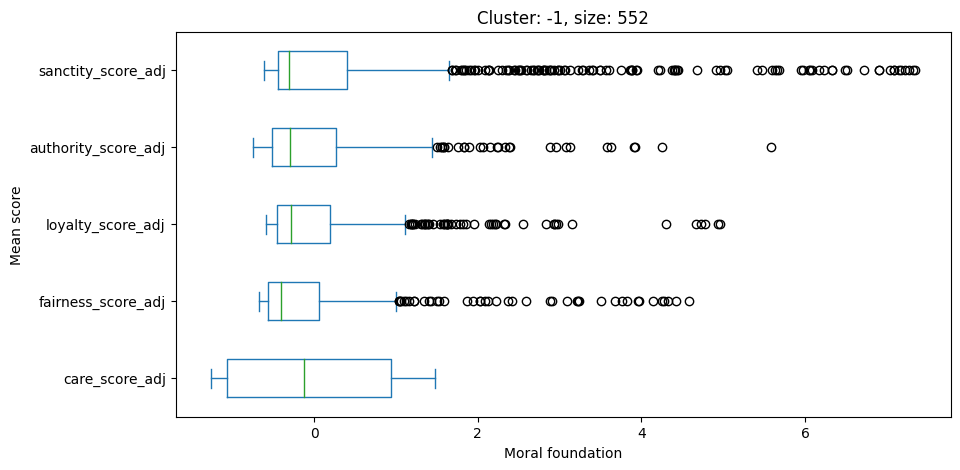

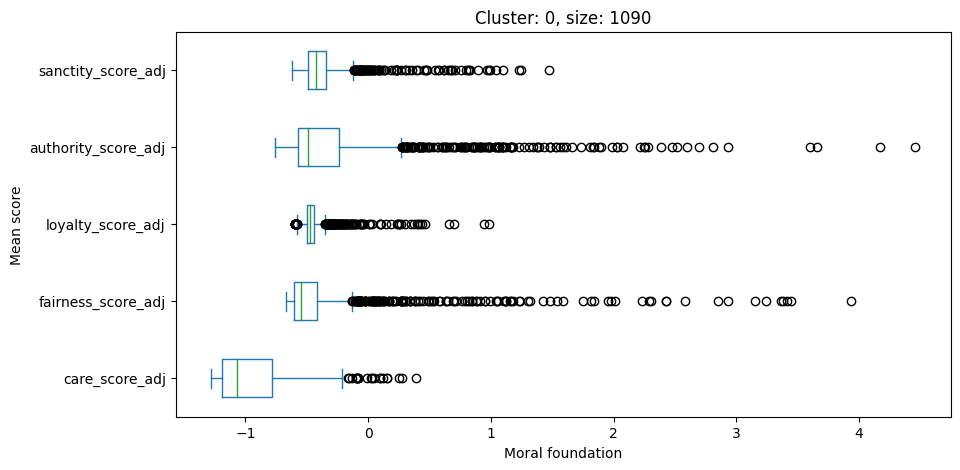

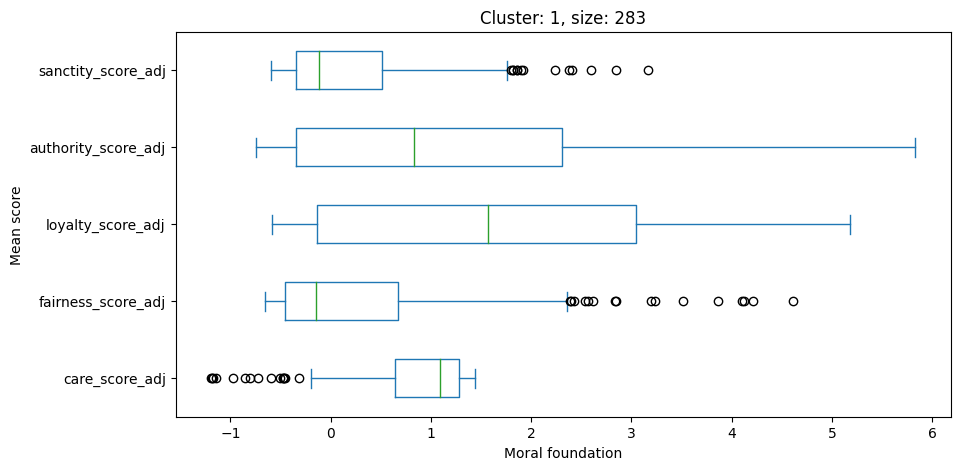

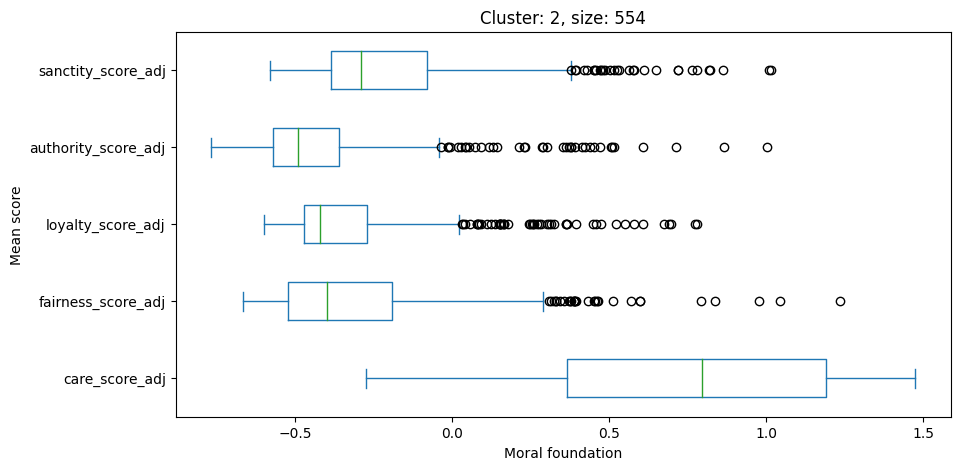

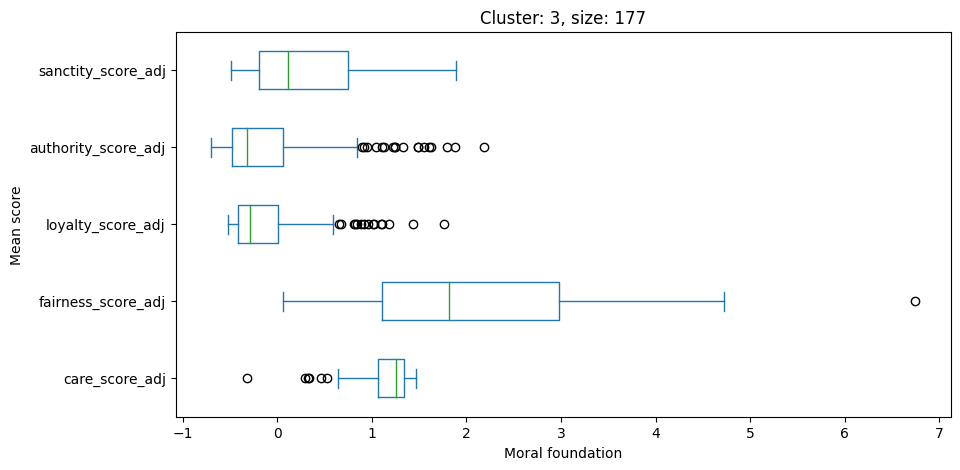

In [102]:
# moral foundations
moral_values = ['care_score_adj', 'fairness_score_adj', 'loyalty_score_adj', 'authority_score_adj', 'sanctity_score_adj']

# for each cluster
for i in unique_labels:
    # if i==-1:
    #     continue

    # columns
    prob_cols = ["prob_cluster"+str(i) for i in range(len(prob[0]))]
    other_cols = ["Video ID", "ci_index", "Video Transcript", 'care_score_adj', 'fairness_score_adj', 'loyalty_score_adj', 'authority_score_adj', 'sanctity_score_adj']
    # save examples of videos in the cluster
    agency_oriented[agency_oriented["hdbscan_labels"]==i][other_cols+prob_cols].to_csv("./data/examples/self_mformer_wisescale_all_noscaled0_cl_"+str(i)+".csv", index=False)

    # get cluster
    cluster = agency_oriented[agency_oriented["hdbscan_labels"]==i]
    # plot barplot for each moral foundation, with confidence intervals
    cluster[moral_values].plot(kind="box", vert=False, figsize=(10, 5))
    # set x axis label
    plt.xlabel("Moral foundation")
    # set y axis label
    plt.ylabel("Mean score")
    # set plot title
    plt.title("Cluster: "+str(i)+", size: "+str(len(cluster)))
    # save as png
    plt.savefig("./pics/self_mformer_wisescale_all_noscaled0_cl_"+str(i)+".png", format="png")